# Introduction

This notebook backtests 100 stock tickers. After reading in the stock tickers from a CSV file, it calls `backtester()` to do all the hard work. This is basically a wrapper for the `backtester()`. The `backtester()` is stored in backtest.py.

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}stocks_100.csv')
idx = (sdf.TICKER > '')
sdf = sdf.loc[idx].reset_index()
tickers = sdf.TICKER.to_list()

In [5]:
%time myPnL_df, my_Capital_df, possible_trades_df, buy_opportunities_df = backtester("backtest_0100.log", tickers, "10y", 10000, 5)

Simulating 93 stocks



local minima and maxima: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]



Unable to determine local minima and maxima for the following tickers:
[]
Simulating with remaining 93 stocks



possible trades: 100%|██████████| 93/93 [02:06<00:00,  1.36s/it]



Possible trades to simulate: 930
Trading days to simulate   : 770



simulate trades: 100%|██████████| 770/770 [01:52<00:00,  6.84it/s]



Today's buying recommendations:

   ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
75   TOWN 2020-02-26      25.67     24.315789  0.501579      0.156316


Yesterday's buying recommendations:

   ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
5    AMWD 2020-02-25      98.47     24.928571  2.857857      0.827143
42    IQV 2020-02-25     150.06     30.166667  7.771667      0.321667
60   PCAR 2020-02-25      69.99     13.666667  1.504444      0.306667
74   TXRH 2020-02-25      66.15     14.882353  0.155294      0.167059
82     VZ 2020-02-25      57.12     15.764706  3.496471      0.157059

CPU times: user 6min 21s, sys: 2.71 s, total: 6min 24s
Wall time: 4min 49s


# Summary Chart

This chart provides an overview of well the backtest went and how it increased or decreased the initial capital over time.

In [6]:
idx = myPnL_df.action=='BUY'
first_buy_date = myPnL_df.loc[idx].date.min()
first_buy_date

Timestamp('2017-02-08 00:00:00')

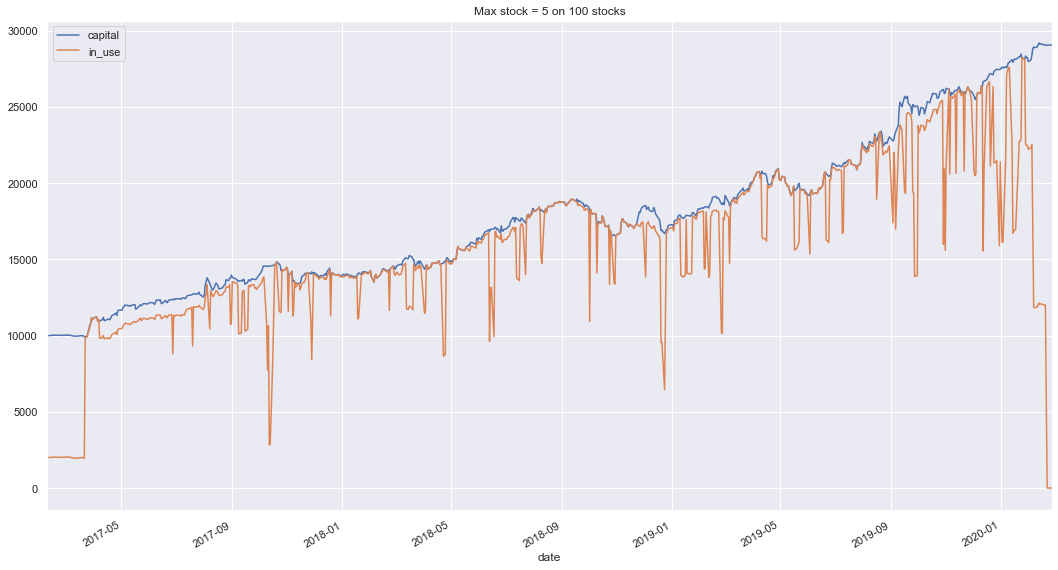

In [7]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols][first_buy_date:].plot(figsize=(18,10))
plt.title('Max stock = 5 on 100 stocks')
plt.show()

# Analysis of Results

The cells below perform a simple analysis. They look at the completed trades. For each trade it calculates the gain and gain percentage. With that it then displays the top ten losses and top ten gains. It ends with calculating the percentage of trades that resulted in a loss.

In [8]:
sell_df = myPnL_df[myPnL_df.action=='SELL'].copy()
sell_df['gain'] = (sell_df.close_amount - sell_df.orig_amount)
sell_df['gain_pct'] = round((sell_df.gain / sell_df.orig_amount)*100, 2)
sell_df['daily_comp_pct'] = (((1 + sell_df.gain_pct/100) ** (1/ sell_df.days_in_trade)) - 1)*100
sell_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-03-23,EPM,SELL,1988.418079,1988.418079,307.338415,5.82282,0.000000e+00,0.000000e+00,2,0,0.000000e+00,0.00,0.000000
0,2017-03-23,TOWN,SELL,1984.745763,1984.745763,68.392342,26.11800,2.273737e-13,1.145606e-14,1,0,2.273737e-13,0.00,0.000000
0,2017-03-24,DLX,SELL,1984.745763,1985.043996,29.823377,59.89500,2.982338e-01,1.502630e-02,2,0,2.982338e-01,0.02,0.010000
0,2017-03-24,CPB,SELL,1988.418079,2006.886358,38.475582,46.51200,-5.386581e+00,-2.676864e-01,3,0,1.846828e+01,0.93,0.309044
0,2017-03-24,FEIM,SELL,1988.418079,1961.054528,182.423677,9.81000,-1.276966e+01,-6.469501e-01,3,0,-2.736355e+01,-1.38,-0.462132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-04,DRI,SELL,5631.830214,5733.036466,49.610907,102.16800,3.175098e+01,5.569092e-01,12,0,1.012063e+02,1.80,0.148777
0,2020-02-05,OTEX,SELL,5620.726098,5589.406150,120.461339,41.99400,-3.131995e+01,-5.572225e-01,2,0,-3.131995e+01,-0.56,-0.280393
0,2020-02-06,TOWN,SELL,5621.248945,5605.043542,202.567530,24.97500,-6.887296e+01,-1.213852e+00,13,0,-1.620540e+01,-0.29,-0.022338
0,2020-02-20,REGN,SELL,5546.596730,6411.806704,16.064054,310.75200,-2.682697e+01,-4.166563e-01,19,0,8.652100e+02,15.60,0.765896


In [9]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 0
Data columns (total 14 columns):
date              295 non-null datetime64[ns]
ticker            295 non-null object
action            295 non-null object
orig_amount       295 non-null float64
close_amount      295 non-null float64
no_shares         295 non-null float64
stop_loss         295 non-null float64
daily_gain        295 non-null float64
daily_pct         295 non-null float64
days_in_trade     295 non-null int64
invested          295 non-null int64
gain              295 non-null float64
gain_pct          295 non-null float64
daily_comp_pct    295 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 34.6+ KB


In [10]:
sell_df.describe()

,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.0,295.000000,295.000000,295.000000
mean,3518.568209,3583.159336,225.352889,43.966495,-9.834917,-0.322403,12.877966,0.0,64.591126,1.977661,0.040290
std,983.243607,1024.912860,524.130386,45.644429,97.720693,2.948776,20.243552,0.0,272.719559,8.334195,1.005149
min,1892.346201,1921.369915,6.039206,0.477000,-684.922897,-23.214794,1.000000,0.0,-677.937149,-21.150000,-10.792377
25%,2753.208396,2771.095862,50.290093,14.548500,-28.546428,-0.841379,2.000000,0.0,-25.641368,-0.840000,-0.207399
50%,3399.684439,3405.254130,120.490151,27.090000,0.000000,0.000000,5.000000,0.0,19.994390,0.540000,0.113035
75%,4094.681639,4200.498883,207.976554,58.167000,27.960297,0.847766,15.000000,0.0,132.003600,3.810000,0.407091
max,5631.830214,6411.806704,6429.137198,330.363000,574.219958,14.551084,172.000000,0.0,2197.416306,68.120000,4.836099


In [11]:
sell_df.sort_values(by='gain_pct', ascending=True)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-11-07,TRIP,SELL,2873.150829,2265.449631,83.936630,30.80700,-684.922897,-23.214794,4,0,-607.701198,-21.15,-5.767563
0,2017-11-02,OPCH,SELL,2751.759963,2189.942304,286.641663,8.64000,-561.817659,-20.416667,2,0,-561.817659,-20.42,-10.792377
0,2017-09-15,TGA,SELL,2732.248800,2338.923294,2310.960669,1.06407,-371.602476,-13.709609,14,0,-393.325506,-14.40,-1.104462
0,2019-12-02,OPCH,SELL,5122.191795,4444.254646,376.631750,12.24000,-241.044320,-5.144695,9,0,-677.937149,-13.24,-1.565664
0,2018-10-02,SYX,SELL,3726.406722,3281.542633,133.995208,25.02900,-96.476549,-2.856010,17,0,-444.864089,-11.94,-0.745161
0,2018-12-24,IQV,SELL,3271.100015,2883.216074,27.277352,107.92800,-68.738926,-2.328590,41,0,-387.883941,-11.86,-0.307438
0,2018-07-23,AGRX,SELL,3407.442715,3008.836208,6429.137198,0.47700,-109.295332,-3.505155,14,0,-398.606506,-11.70,-0.884848
0,2019-06-03,PSDO,SELL,4150.327561,3673.408935,283.880134,13.15800,-68.131232,-1.820941,38,0,-476.918625,-11.49,-0.320681
0,2018-12-20,CVI,SELL,3297.912116,2923.701634,97.197528,30.53700,-117.609009,-3.867050,19,0,-374.210482,-11.35,-0.632068
0,2017-10-25,MBI,SELL,2918.405925,2589.512818,416.320389,6.30900,-179.017767,-6.466165,7,0,-328.893107,-11.27,-1.693667


In [12]:
sell_df.sort_values(by='gain_pct', ascending=False)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-04-07,SYX,SELL,1987.404885,3341.201480,393.545522,4.545,31.483642,0.951249,11,0,1353.796595,68.12,4.836099
0,2019-09-05,MEDP,SELL,3751.283007,5948.699313,71.904984,46.953,96.352678,1.646394,128,0,2197.416306,58.58,0.360875
0,2018-11-26,OPCH,SELL,3494.189530,4520.454986,305.436148,10.296,574.219958,14.551084,30,0,1026.265456,29.37,0.862049
0,2019-08-21,PRPL,SELL,4181.859327,5253.460780,653.415520,5.760,-65.341552,-1.228501,14,0,1071.601453,25.62,1.642568
0,2017-09-08,SYX,SELL,2541.911292,3182.586332,188.989687,12.105,-64.256494,-1.979045,36,0,640.675039,25.20,0.626237
0,2018-03-05,PANW,SELL,2579.841201,3182.127768,17.652010,131.535,61.782034,1.979974,48,0,602.286567,23.35,0.438156
0,2018-08-10,IQV,SELL,3387.440932,4070.910316,33.602231,90.729,-18.481227,-0.451931,34,0,683.469384,20.18,0.542112
0,2018-05-21,VSH,SELL,2961.702477,3514.348289,171.097775,15.579,49.618355,1.432099,13,0,552.645812,18.66,1.324792
0,2019-09-27,SPPI,SELL,4585.552669,5395.484282,608.971138,6.777,-164.422207,-2.957284,17,0,809.931613,17.66,0.961231
0,2018-02-27,OPCH,SELL,2773.255869,3251.045269,259.668152,9.612,41.546904,1.294498,16,0,477.789401,17.23,0.998500


In [13]:
sell_df[sell_df.gain_pct < 0].count()[0], sell_df[sell_df.gain_pct < 0].count()[0]/len(sell_df)

(106, 0.3593220338983051)

In [14]:
myPnL_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested
0,2017-02-08,ORIT,BUY,2000.000000,2000.000000,141.242938,12.744,0.000000,0.000000,0,0
0,2017-02-08,ORIT,CLOSE,2000.000000,2000.000000,141.242938,12.744,0.000000,0.000000,1,0
0,2017-02-09,ORIT,CLOSE,2000.000000,2007.062147,141.242938,12.744,7.062147,0.353107,2,0
0,2017-02-10,ORIT,CLOSE,2000.000000,1994.350282,141.242938,12.744,-12.711864,-0.633357,3,0
0,2017-02-13,ORIT,CLOSE,2000.000000,2012.711864,141.242938,12.744,18.361582,0.920680,4,0
...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-19,CPB,CLOSE,5543.894446,5563.685753,116.419455,42.858,-47.731977,-0.850622,28,0
0,2020-02-19,REGN,CLOSE,5546.596730,6438.633675,16.064054,310.752,50.762412,0.794669,18,0
0,2020-02-20,REGN,SELL,5546.596730,6411.806704,16.064054,310.752,-26.826971,-0.416656,19,0
0,2020-02-20,CPB,CLOSE,5543.894446,5557.864780,116.419455,42.858,-5.820973,-0.104624,29,0


In [15]:
sell_df.ticker.unique(), len(sell_df.ticker.unique())

(array(['EPM', 'TOWN', 'DLX', 'CPB', 'FEIM', 'GRIF', 'VZ', 'JVA', 'GS',
        'SYX', 'MBI', 'AMWD', 'REGN', 'CVI', 'MDP', 'BLDR', 'OPCH', 'PEBK',
        'SPPI', 'VSH', 'AMT', 'HWC', 'CRL', 'TRNS', 'OTEX', 'VIVO', 'FCFS',
        'DRI', 'GWB', 'TGA', 'PGR', 'BXP', 'ORIT', 'DSGX', 'PCAR', 'TRIP',
        'SLG', 'FHB', 'MRC', 'USPH', 'IPG', 'BOCH', 'PANW', 'ORC', 'CVX',
        'BMCH', 'IQV', 'HLT', 'EXLS', 'AGRX', 'LIND', 'AA', 'DRQ', 'PRPL',
        'DERM', 'PSDO', 'MEDP', 'JELD', 'FOR', 'TXRH'], dtype=object), 60)

In [16]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
50,SYX,2974.641853
35,MEDP,2197.416306
5,BMCH,1341.273680
54,TRNS,1122.792402
49,SPPI,1121.261477
9,CRL,1108.458378
4,BLDR,915.422474
47,REGN,903.740106
2,AMT,874.719437
14,DRI,869.447496


In [17]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
51,TGA,-740.409460
1,AGRX,-592.095324
46,PSDO,-476.918625
53,TRIP,-471.634724
33,MBI,-457.917347
43,PEBK,-249.254826
19,FCFS,-211.126717
0,AA,-161.325257
57,VIVO,-125.100559
27,HWC,-77.821842


In [18]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
35,MEDP,2197.416306
47,REGN,451.870053
30,JELD,410.514426
50,SYX,297.464185
32,LIND,236.608018
45,PRPL,215.818800
38,ORC,182.081663
39,ORIT,168.740845
5,BMCH,167.659210
22,FOR,144.105684


In [19]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
46,PSDO,-476.918625
1,AGRX,-296.047662
51,TGA,-246.803153
0,AA,-80.662629
12,DERM,-76.032981
19,FCFS,-70.375572
33,MBI,-65.416764
53,TRIP,-52.403858
57,VIVO,-41.700186
43,PEBK,-41.542471


In [20]:
myCapital_df.tail()

,date,capital,in_use,free
date,,,,
2020-02-20,2020-02-20,29028.8,5557.86,23470.9
2020-02-21,2020-02-21,29054.4,0,29054.4
2020-02-24,2020-02-24,29054.4,0,29054.4
2020-02-25,2020-02-25,29054.4,0,29054.4
2020-02-26,2020-02-26,29054.4,0,29054.4


In [21]:
len(possible_trades_df)

930

# Save The DataFrames

In [22]:
possible_trades_df.to_csv(f'{DATAPATH}possible_trades_0100.csv', index=False)
myCapital_df.to_csv(f'{DATAPATH}capital_0100.csv', index=False)
myPnL_df.to_csv(f'{DATAPATH}PnL_0100.csv', index=False)

In [23]:
!ls ../data

F13_Renaissance_tech.csv capital_0500.csv         possible_trades_1000.csv
F13_Renaissance_tech.txt capital_1000.csv         possible_trades_1500.csv
PnL_0100.csv             capital_1500.csv         possible_trades_2000.csv
PnL_0500.csv             capital_2000.csv         stocks.csv
PnL_1000.csv             exclude.csv              stocks_100.csv
PnL_1500.csv             optimal_params.csv       stocks_1000.csv
PnL_2000.csv             possible_trades_0100.csv stocks_2000.csv
capital_0100.csv         possible_trades_0500.csv stocks_500.csv


In [24]:
cols = ['ticker', 'trading_days', 'gain_pct', 'daily_return']
mean_df = possible_trades_df[cols].groupby('ticker').agg(['mean']).reset_index()
mean_df.columns=['ticker', 'trading_days', 'gain_pct', 'daily_return']
mean_df

,ticker,trading_days,gain_pct,daily_return
0,AA,14.300000,0.160000,-0.080000
1,ADRO,68.000000,-29.645000,0.060000
2,AGRX,57.500000,32.070000,0.200000
3,ALXN,85.600000,-2.970000,-0.034000
4,AMT,32.692308,4.407692,0.147692
...,...,...,...,...
80,USPH,25.363636,3.235455,0.259091
81,VIVO,29.125000,0.688750,0.048750
82,VSH,20.055556,4.311667,-0.323889
83,VZ,15.764706,3.496471,0.157059
